# Imports

In [ ]:
pip install emoji

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 433.8/433.8 kB 4.2 MB/s eta 0:00:00


In [ ]:
import re
import tqdm
import keras
import numpy as np
import pandas as pd

import google.generativeai as genai
import google.ai.generativelanguage as glm

# Used to securely store your API key
from google.colab import userdata

import seaborn as sns
import matplotlib.pyplot as plt

from keras import layers
from matplotlib.ticker import MaxNLocator
from sklearn.datasets import fetch_20newsgroups
import sklearn.metrics as skmetrics

#Setting UP API

In [ ]:
# Or use `os.getenv('API_KEY')` to fetch an environment variable.
API_KEY=userdata.get('API_KEY')

genai.configure(api_key=API_KEY)

## Getting list of Models

In [ ]:
for m in genai.list_models():
  if 'embedContent' in m.supported_generation_methods:
    print(m.name)

models/embedding-001
models/text-embedding-004


## Selecting Model

In [ ]:
model = 'models/embedding-001'

# Data Prep

In [ ]:
# Load and prepare data
def load_data(file_path, subreddit_name):
    data = pd.read_csv(file_path)
    data['subreddit'] = subreddit_name
    return data

rutgers_data = load_data('/content/drive/MyDrive/Projects /ML for DS/data/rutgers_submission.csv', 'Rutgers')
upenn_data = load_data('/content/drive/MyDrive/Projects /ML for DS/data/UPenn_submission.csv', 'UPenn')

# Combine and filter data
combined_data = pd.concat([rutgers_data, upenn_data], ignore_index=True)
combined_data['created'] = pd.to_datetime(combined_data['created'])

filtered_data = combined_data[(combined_data['subreddit'].isin(['Rutgers', 'UPenn'])) &
                              (combined_data['created'].dt.year.isin([2021, 2022]))]

In [ ]:
filtered_data

,author,title,score,created,link,text,url,subreddit
88212,u/[deleted],Some of you liberals,0,2021-01-01 05:40:00,https://www.reddit.com/r/rutgers/comments/ko9a...,[removed],https://www.reddit.com/r/rutgers/comments/ko9a...,Rutgers
88213,u/Ozymandias--,Rutgers officially announces plans to re-open ...,357,2021-01-01 06:48:00,https://www.reddit.com/r/rutgers/comments/koa2...,NaN,https://newbrunswicktoday.com/2020/12/31/rutge...,Rutgers
88214,u/[deleted],what should i do in terms of P/NC,6,2021-01-01 09:41:00,https://www.reddit.com/r/rutgers/comments/koca...,[deleted],https://www.reddit.com/r/rutgers/comments/koca...,Rutgers
88215,u/kingcam321,Syllabus for Orgo 2?,7,2021-01-01 11:09:00,https://www.reddit.com/r/rutgers/comments/kodp...,Does anyone have the syllabus for orgo 2? I di...,https://www.reddit.com/r/rutgers/comments/kodp...,Rutgers
88216,u/[deleted],Is Jimenez going to post the results to the Fi...,4,2021-01-01 11:10:00,https://www.reddit.com/r/rutgers/comments/kodq...,[deleted],https://www.reddit.com/r/rutgers/comments/kodq...,Rutgers
...,...,...,...,...,...,...,...,...
151909,u/softalmondmilk,SUPPLEMENTAL ESSAY,1,2022-12-31 03:56:00,https://www.reddit.com/r/UPenn/comments/zzpsgn...,[removed],https://www.reddit.com/r/UPenn/comments/zzpsgn...,UPenn
151910,u/softalmondmilk,ISP and BFS,3,2022-12-31 10:13:00,https://www.reddit.com/r/UPenn/comments/zzw6fa...,I was hoping to know if ISP is still offered f...,https://www.reddit.com/r/UPenn/comments/zzw6fa...,UPenn
151911,u/[deleted],Is my schedule too much work?,1,2022-12-31 12:47:00,https://www.reddit.com/r/UPenn/comments/zzzhvj...,[deleted],NaN,UPenn
151912,u/itsamayzing,Does anyone know what topics are covered in ST...,5,2022-12-31 16:24:00,https://www.reddit.com/r/UPenn/comments/100425...,Going straight into stat 1020 because I had a ...,https://www.reddit.com/r/UPenn/comments/100425...,UPenn


In [ ]:
import pandas as pd
import re
import string
import emoji
import nltk

# Ensure necessary NLTK resources are available
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

# Data Cleaning and Preprocessing
def clean_text(text):
    text = emoji.replace_emoji(text, replace='')
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'[\t\n\r]+', ' ', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r'\w*\d\w*', '', text)
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)
    text = text.strip()
    # Filter out any strings that have become empty after cleaning
    return text if text else None

def process_text(text):
    if text is None:  # If text is None, skip processing
        return None
    stopwords = set(nltk.corpus.stopwords.words("english")) - set(["not"])
    lemmatizer = nltk.stem.WordNetLemmatizer()
    tokens = nltk.word_tokenize(text)
    processed_text = [lemmatizer.lemmatize(word) for word in tokens if word.lower() not in stopwords]
    # Create a combined string and filter out any that would be empty
    processed = " ".join(processed_text)
    return processed if processed else None

# Apply cleaning and processing to the dataset
filtered_data['cleaned_title'] = filtered_data['title'].apply(clean_text)
filtered_data['processed_title'] = filtered_data['cleaned_title'].apply(process_text)

# Drop any rows where 'processed_title' is None
filtered_data = filtered_data.dropna(subset=['processed_title'])

print("Data after cleaning and processing:", filtered_data.head())

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
<ipython-input-8-153e176c1b04>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['cleaned_title'] = filtered_data['title'].apply(clean_text)


Data after cleaning and processing:                author                                              title  \
88212     u/[deleted]                               Some of you liberals   
88213  u/Ozymandias--  Rutgers officially announces plans to re-open ...   
88214     u/[deleted]                  what should i do in terms of P/NC   
88215    u/kingcam321                               Syllabus for Orgo 2?   
88216     u/[deleted]  Is Jimenez going to post the results to the Fi...   

       score             created  \
88212      0 2021-01-01 05:40:00   
88213    357 2021-01-01 06:48:00   
88214      6 2021-01-01 09:41:00   
88215      7 2021-01-01 11:09:00   
88216      4 2021-01-01 11:10:00   

                                                    link  \
88212  https://www.reddit.com/r/rutgers/comments/ko9a...   
88213  https://www.reddit.com/r/rutgers/comments/koa2...   
88214  https://www.reddit.com/r/rutgers/comments/koca...   
88215  https://www.reddit.com/r/rutgers/comments/k

<ipython-input-8-153e176c1b04>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['processed_title'] = filtered_data['cleaned_title'].apply(process_text)


In [ ]:
filtered_data = filtered_data[filtered_data['processed_title'] != 'deleted user']
filtered_data = filtered_data[filtered_data['processed_title'].str.strip() != '']

In [ ]:
df = filtered_data[['subreddit','processed_title']]
df

,subreddit,processed_title
88212,Rutgers,liberal
88213,Rutgers,Rutgers officially announces plan reopen campu...
88214,Rutgers,term PNC
88215,Rutgers,Syllabus Orgo
88216,Rutgers,Jimenez going post result Final Exam
...,...,...
151909,UPenn,SUPPLEMENTAL ESSAY
151910,UPenn,ISP BFS
151911,UPenn,schedule much work
151912,UPenn,anyone know topic covered STAT


In [ ]:
# Random sampling
sampled_data = df.groupby('subreddit').sample(n=2000, random_state=1)

In [ ]:
sampled_data.value_counts("processed_title")

processed_title
CIS                        7
Housing                    4
summer                     3
Friends                    3
v                          3
                          ..
MAE Technical Electives    1
MATH Help                  1
MATH Ideas Mathematics     1
MATH MATH                  1
…                          1
Name: count, Length: 3943, dtype: int64

Now that the df is ready lets work on it

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

def sample_and_encode_data(df, num_samples=None):
    # Sample data if num_samples is specified
    if num_samples:
        df = df.groupby('subreddit', as_index=False).apply(lambda x: x.sample(num_samples, replace=True, random_state=42)).reset_index(drop=True)

    # Encode the 'color' column as categorical codes
    df['subreddit'] = df['subreddit'].astype('category')
    df['Encoded Label'] = df['subreddit'].cat.codes

    return df

# Assuming 'df' is your full DataFrame
# Splitting the data into train and test sets
train_size = 0.70
df_train, df_test = train_test_split(df, stratify=df['subreddit'], train_size=train_size, test_size=0.30, random_state=42)

# Optionally balance classes in training data
BALANCE_SAMPLES = 1000  # We will be downsampeling our dataset
df_train = sample_and_encode_data(df_train, BALANCE_SAMPLES)
df_test = sample_and_encode_data(df_test)  # No balancing for test data, just encoding

# Check the distribution of classes and the head of the datasets to confirm setup
print(df_train.value_counts('subreddit'))
print(df_test.value_counts('subreddit'))
print(df_train.head())
print(df_test.head())

subreddit
Rutgers    1000
UPenn      1000
Name: count, dtype: int64
subreddit
Rutgers    10951
UPenn       3608
Name: count, dtype: int64
  subreddit                                    processed_title  Encoded Label
0   Rutgers  girl currently not oncampus housing would like...              0
1   Rutgers                 Livingston Dining Hall Guest Swipe              0
2   Rutgers                                          bus route              0
3   Rutgers  Hypothetical question allowed store gallon liq...              0
4   Rutgers               get another covid relief fund spring              0
       subreddit                                    processed_title  \
142320     UPenn                freshman take course first semester   
145166     UPenn       UPenn Masters Biotechnology v Bioengineering   
106086   Rutgers                                          Fun class   
108742   Rutgers  ’ Social Media amp Work KerrMccurry credit cou...   
95253    Rutgers                       

#Generating Embeddings

In [ ]:
from tqdm.auto import tqdm
tqdm.pandas()

from google.api_core import retry

def make_embed_text_fn(model):

  @retry.Retry(timeout=300.0)
  def embed_fn(text: str) -> list[float]:
    # Set the task_type to CLASSIFICATION.
    embedding = genai.embed_content(model=model,
                                    content=text,
                                    task_type="classification")
    return embedding['embedding']

  return embed_fn

def create_embeddings(model, df):
  df['Embeddings'] = df['processed_title'].progress_apply(make_embed_text_fn(model))
  return df

In [ ]:
# model = 'models/embedding-001'
# df_train = create_embeddings(model, df_train)
# df_test = create_embeddings(model, df_test)

In [ ]:
df_train=pd.read_csv('/content/drive/MyDrive/Projects /ML for DS/df_train.csv')
df_test=pd.read_csv('/content/drive/MyDrive/Projects /ML for DS/df_test.csv')

In [ ]:
df_train

,Unnamed: 0,subreddit,processed_title,Encoded Label,Embeddings
0,0,Rutgers,girl currently not oncampus housing would like...,0,"[0.017395863, -0.03309162, -0.026439212, -0.07..."
1,1,Rutgers,Livingston Dining Hall Guest Swipe,0,"[0.04196943, -0.011381745, -0.057876058, -0.05..."
2,2,Rutgers,bus route,0,"[0.016273398, -0.030588085, -0.05447116, -0.04..."
3,3,Rutgers,Hypothetical question allowed store gallon liq...,0,"[-0.013889403, -0.06625572, -0.052370287, -0.0..."
4,4,Rutgers,get another covid relief fund spring,0,"[0.003015446, -0.0065499432, -0.0581211, -0.04..."
...,...,...,...,...,...
1995,1995,UPenn,schedule vaccine schedule one dose,1,"[0.004068121, -0.06631477, -0.033852454, -0.04..."
1996,1996,UPenn,everyone get preorientation program acceptance...,1,"[0.021544827, -0.039928205, -0.019442463, -0.0..."
1997,1997,UPenn,prof better,1,"[0.013047099, -0.016865127, 0.027865369, -0.02..."
1998,1998,UPenn,Penn building still closed,1,"[0.03347769, -0.01859094, -0.026078595, -0.057..."


#Lets build a simple classification model

In [ ]:
import ast
df_train['Embeddings'] = df_train['Embeddings'].apply(ast.literal_eval)
df_test['Embeddings'] = df_test['Embeddings'].apply(ast.literal_eval)

In [ ]:
from keras.models import Model
from keras.layers import Input, Dense
from keras.optimizers import Adam
import keras

In [ ]:
def build_classification_model(input_size: int) -> keras.Model:
    # Define input layer
    inputs = Input(shape=(input_size,))

    # Add hidden layer with ReLU activation
    x = Dense(64, activation='relu')(inputs)

    # Output layer with sigmoid activation for binary classification
    outputs = Dense(1, activation='sigmoid')(x)

    # Create and return the model
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [ ]:
# Derive the embedding size from the first training element
embedding_size = len(df_train['Embeddings'].iloc[0])

# Build the classification model
classifier = build_classification_model(embedding_size)
classifier.summary()

# Compile the model for binary classification
classifier.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=0.0001),
    metrics=['accuracy']
)

Model: "model_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_17 (InputLayer)       [(None, 768)]             0         
                                                                 
 dense_24 (Dense)            (None, 64)                49216     
                                                                 
 dense_25 (Dense)            (None, 1)                 65        
                                                                 
Total params: 49281 (192.50 KB)
Trainable params: 49281 (192.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


##Train the model to classify Reddit titles

In [ ]:
# Specify number of epochs and batch size for training
NUM_EPOCHS = 20
BATCH_SIZE = 5

# Extract labels and convert embeddings list into a numpy array for training
y_train = df_train['Encoded Label']
x_train = np.stack(df_train['Embeddings'])
y_val = df_test['Encoded Label']
x_val = np.stack(df_test['Embeddings'])

# Setup early stopping callback to prevent overfitting
callback = keras.callbacks.EarlyStopping(monitor='accuracy', patience=3)

# Train the model
history = classifier.fit(
    x=x_train,
    y=y_train,
    validation_data=(x_val, y_val),
    callbacks=[callback],
    batch_size=BATCH_SIZE,
    epochs=NUM_EPOCHS,
)

Epoch 1/20
400/400 [==============================] - 12s 29ms/step - loss: 0.6902 - accuracy: 0.5450 - val_loss: 0.6853 - val_accuracy: 0.6262
Epoch 2/20
400/400 [==============================] - 5s 12ms/step - loss: 0.6789 - accuracy: 0.6225 - val_loss: 0.6867 - val_accuracy: 0.5229
Epoch 3/20
400/400 [==============================] - 12s 30ms/step - loss: 0.6661 - accuracy: 0.6480 - val_loss: 0.6845 - val_accuracy: 0.5180
Epoch 4/20
400/400 [==============================] - 8s 19ms/step - loss: 0.6534 - accuracy: 0.6730 - val_loss: 0.6573 - val_accuracy: 0.6492
Epoch 5/20
400/400 [==============================] - 5s 13ms/step - loss: 0.6404 - accuracy: 0.6815 - val_loss: 0.6424 - val_accuracy: 0.6742
Epoch 6/20
400/400 [==============================] - 5s 12ms/step - loss: 0.6270 - accuracy: 0.6920 - val_loss: 0.6268 - val_accuracy: 0.6917
Epoch 7/20
400/400 [==============================] - 7s 17ms/step - loss: 0.6150 - accuracy: 0.6950 - val_loss: 0.6229 - val_accuracy: 0.67

#Evaluate model performance

In [ ]:
x_val = np.stack(df_test['Embeddings'].values)

print("Shape of x_val:", x_val.shape)
print("Shape of y_val:", y_val.shape)

Shape of x_val: (14559, 768)
Shape of y_val: (14559,)


In [ ]:
results = classifier.evaluate(x=x_val, y=y_val, return_dict=True)
print("Evaluation results:", results)

455/455 [==============================] - 1s 2ms/step - loss: 0.5539 - accuracy: 0.7022
Evaluation results: {'loss': 0.553912341594696, 'accuracy': 0.7021773457527161}


## Lets plot the loss and acuracy over epochs

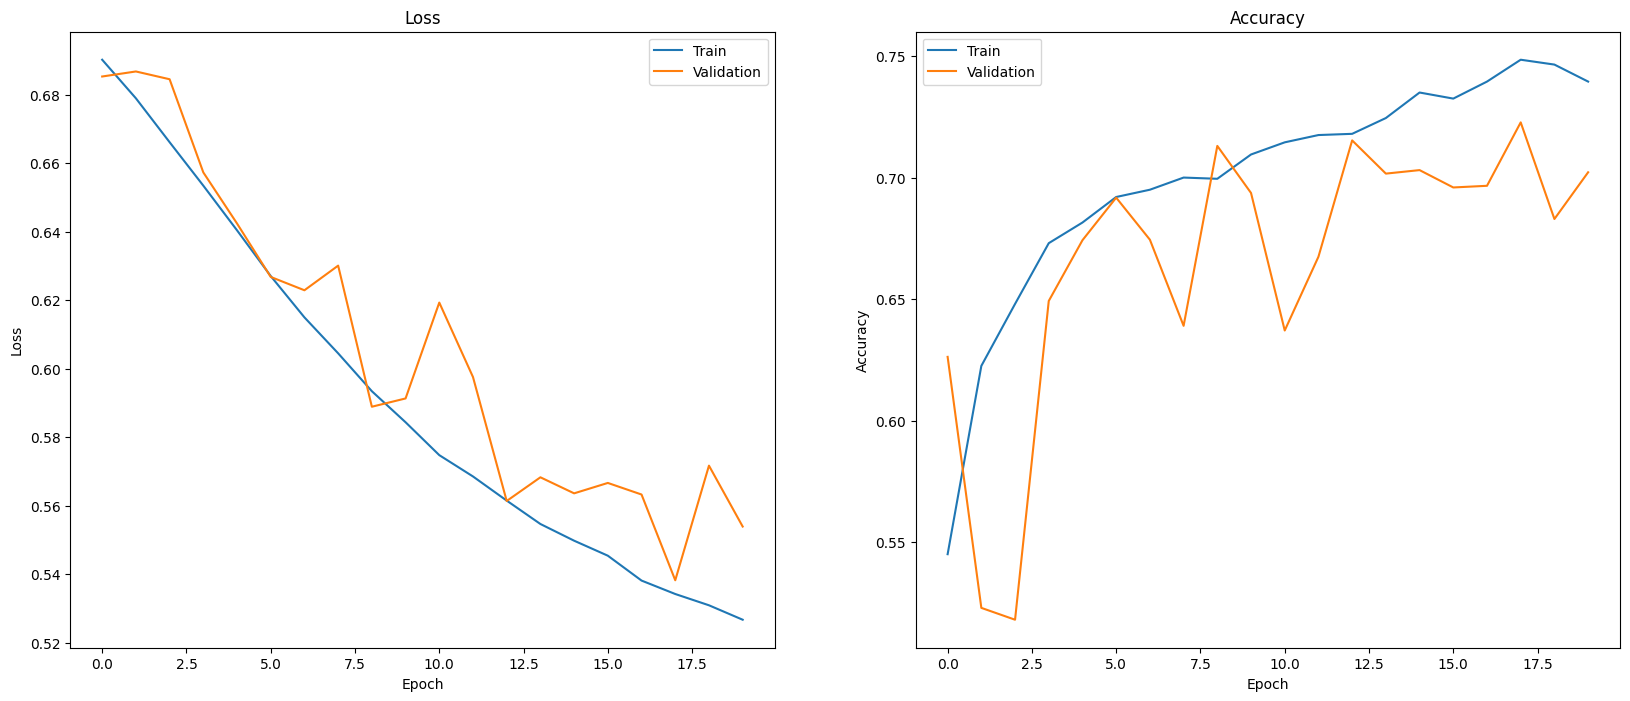

In [ ]:
def plot_history(history):
  """
    Plotting training and validation learning curves.

    Args:
      history: model history with all the metric measures
  """
  fig, (ax1, ax2) = plt.subplots(1,2)
  fig.set_size_inches(20, 8)

  # Plot loss
  ax1.set_title('Loss')
  ax1.plot(history.history['loss'], label = 'train')
  ax1.plot(history.history['val_loss'], label = 'test')
  ax1.set_ylabel('Loss')

  ax1.set_xlabel('Epoch')
  ax1.legend(['Train', 'Validation'])

  # Plot accuracy
  ax2.set_title('Accuracy')
  ax2.plot(history.history['accuracy'],  label = 'train')
  ax2.plot(history.history['val_accuracy'], label = 'test')
  ax2.set_ylabel('Accuracy')
  ax2.set_xlabel('Epoch')
  ax2.legend(['Train', 'Validation'])

  plt.show()

plot_history(history)

## Plotting the Confusion Matrix

In [ ]:
y_hat = classifier.predict(x=x_val)
y_hat = np.argmax(y_hat, axis=1)

455/455 [==============================] - 2s 4ms/step


In [ ]:
labels_dict = dict(zip(df_test['subreddit'], df_test['Encoded Label']))
labels_dict

{'UPenn': 1, 'Rutgers': 0}

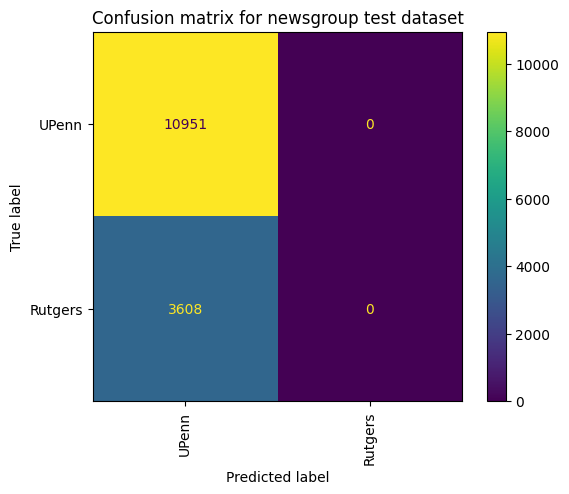

In [ ]:
cm = skmetrics.confusion_matrix(y_val, y_hat)
disp = skmetrics.ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=labels_dict.keys())
disp.plot(xticks_rotation='vertical')
plt.title('Confusion matrix for newsgroup test dataset');
plt.grid(False)

455/455 [==============================] - 1s 3ms/step


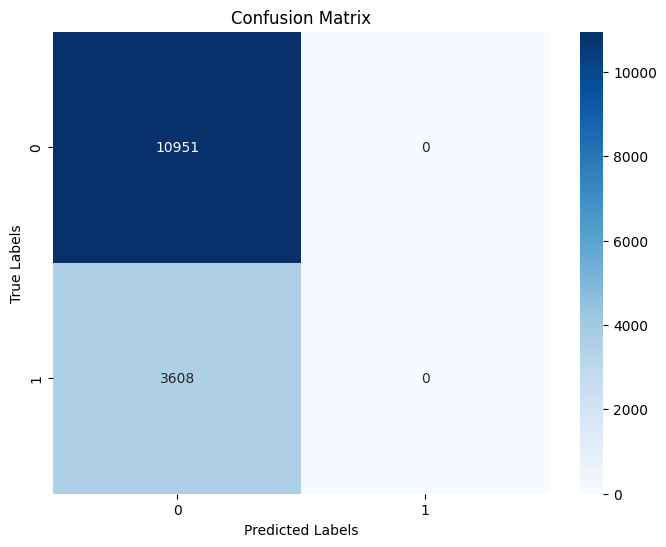

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Predict classes using the trained classifier
y_pred = classifier.predict(x_val)
y_pred_classes = np.argmax(y_pred, axis=1)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_val, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

##ROC for Keras Model

In [ ]:
# Assuming y_scores_keras is the output of classifier.predict(x_val) and it's correctly shaped
y_scores_keras = classifier.predict(x_val).squeeze()

# Check the shape after squeezing to make sure it's now a one-dimensional array
print("y_scores_keras shape after squeezing:", y_scores_keras.shape)

# Now, y_scores_keras should have the same length as y_val
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_val, y_scores_keras)
roc_auc_keras = auc(fpr_keras, tpr_keras)

# Display ROC AUC
print("ROC AUC for Keras Model:", roc_auc_keras)

455/455 [==============================] - 1s 2ms/step
y_scores_keras shape after squeezing: (14559,)
ROC AUC for Keras Model: 0.7555850987901964


In [ ]:
# Assuming y_scores_keras is the output of classifier.predict(x_val) and it's correctly shaped
y_scores_keras = classifier.predict(x_val)

fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_val, y_scores_keras.ravel())
roc_auc_keras = auc(fpr_keras, tpr_keras)

# Display ROC AUC
print("ROC AUC for Keras Model:", roc_auc_keras)

455/455 [==============================] - 1s 2ms/step
ROC AUC for Keras Model: 0.7555850987901964


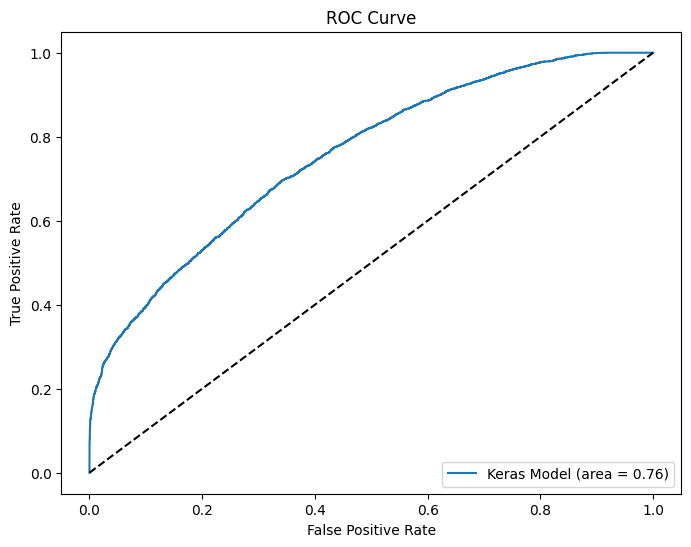

In [ ]:
# Optionally, plot the ROC curve
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(fpr_keras, tpr_keras, label='Keras Model (area = {:.2f})'.format(roc_auc_keras))
plt.plot([0, 1], [0, 1], 'k--')  # Dashed diagonal
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

#SHAP for Model Test

In [ ]:
pip install shap

/usr/local/lib/python3.10/dist-packages/shap/explainers/_deep/deep_tf.py:99: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn("Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.")
/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:452: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


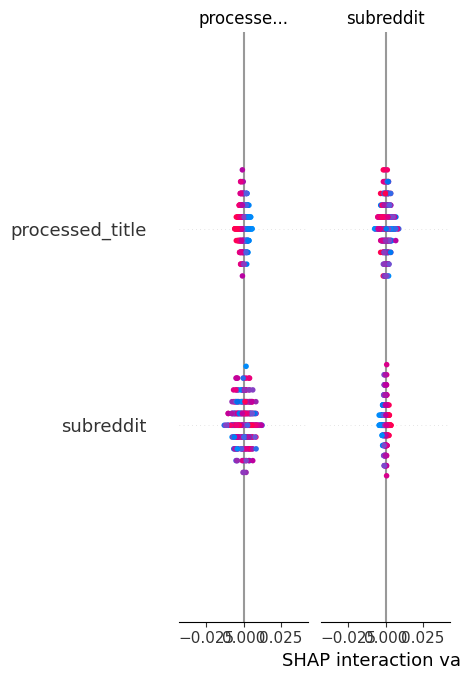

In [ ]:
import shap

# Initialize a SHAP Deep Explainer with more data points if possible
explainer = shap.DeepExplainer(classifier, x_train[:100])

# Compute SHAP values for a larger subset of your test data, if computational resources allow
shap_values = explainer.shap_values(x_val[:300])  # Adjust the number based on your dataset

# Make a bar plot instead of beeswarm for clearer feature importance visualization
shap.summary_plot(shap_values, features=x_val[:300], feature_names=df.columns, plot_type='bar')

#TSV file creation

In [ ]:
# Concatenate the embeddings from both the training and test sets
all_embeddings = pd.concat([df_train['Embeddings'], df_test['Embeddings']], ignore_index=True)

# Convert each list of embeddings in the series to a separate row in a new dataframe
embeddings_df = pd.DataFrame(all_embeddings.tolist())

# Save this dataframe to a TSV file
embeddings_tsv_path = 'all_embeddings.tsv'
embeddings_df.to_csv(embeddings_tsv_path, sep='\t', index=False, header=False)

embeddings_tsv_path

'all_embeddings.tsv'

# Treditional ML

In [ ]:
def sample_and_encode_data(df, num_samples=None):
    # Sample data if num_samples is specified
    if num_samples:
        df = df.groupby('subreddit', as_index=False).apply(lambda x: x.sample
         (num_samples, replace=True, random_state=42)).reset_index(drop=True)

    # Encode the 'subreddit' column as categorical codes
    df['subreddit'] = df['subreddit'].astype('category')
    df['Encoded Label'] = df['subreddit'].cat.codes

    return df

# Now call this function on your DataFrame
df_encoded = sample_and_encode_data(sampled_data)

In [ ]:
df_encoded

,subreddit,processed_title,Encoded Label
88842,Rutgers,Intro Environmental Science Francisco,0
117664,Rutgers,Rutgers invest money Computer Science,0
99275,Rutgers,get football ticket,0
120847,Rutgers,Schedule change help,0
100947,Rutgers,feel like ’ behind prebusiness reqs first year...,0
...,...,...,...
145793,UPenn,Picking book course reserve,1
141527,UPenn,Reliable Summer Storage Options near Penn,1
141252,UPenn,Anyone Percec Orgo previously,1
150549,UPenn,Anyone going Boston fall break,1


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Vectorize the processed titles
vectorizer = TfidfVectorizer(max_features=5000)  # Adjust the number of max_features as needed
X = vectorizer.fit_transform(df_encoded['processed_title']).toarray()

# The labels are already encoded in your 'Encoded Label' column
y = df_encoded['Encoded Label'].values

# Use the same train-test split you used for the Keras model
train_size = 0.70
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, train_size=train_size, test_size=0.30, random_state=42)

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier

# List of models
models = [
    DecisionTreeClassifier(),
    LogisticRegression(max_iter=1000),
    SVC(),
    RandomForestClassifier(),
    BernoulliNB(),
    KNeighborsClassifier()
]

model_names = ["Decision Tree", "Logistic Regression", "SVC", "Random Forest", "Naive Bayes", "K-Neighbors"]

# Initialize dictionary to store accuracies
model_accuracies = {}

# Training and Evaluating Models
for model, name in zip(models, model_names):
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    model_accuracies[name] = accuracy  # Store the accuracy in the dictionary
    print(f"{name} Test Accuracy: {accuracy:.2f}")
    print("Confusion Matrix:\n", confusion_matrix(y_test, predictions))
    print("Classification Report:\n", classification_report(y_test, predictions))

# Identify the best performing model
best_model_name = max(model_accuracies, key=model_accuracies.get)
best_accuracy = model_accuracies[best_model_name]
print(f"The best performing model is: {best_model_name} with an accuracy of {best_accuracy:.2f}")

# Select the best model
best_model = models[model_names.index(best_model_name)]

Decision Tree Test Accuracy: 0.68
Confusion Matrix:
 [[445 155]
 [234 366]]
Classification Report:
               precision    recall  f1-score   support

           0       0.66      0.74      0.70       600
           1       0.70      0.61      0.65       600

    accuracy                           0.68      1200
   macro avg       0.68      0.68      0.67      1200
weighted avg       0.68      0.68      0.67      1200

Logistic Regression Test Accuracy: 0.71
Confusion Matrix:
 [[420 180]
 [162 438]]
Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.70      0.71       600
           1       0.71      0.73      0.72       600

    accuracy                           0.71      1200
   macro avg       0.72      0.71      0.71      1200
weighted avg       0.72      0.71      0.71      1200

SVC Test Accuracy: 0.72
Confusion Matrix:
 [[439 161]
 [170 430]]
Classification Report:
               precision    recall  f1-score   supp

## Grid Search on Best Model

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Define parameter grids for each model
param_grids = {
    "Decision Tree": {
        "max_depth": [None, 10, 20, 30],
        "min_samples_split": [2, 5, 10]
    },
    "Logistic Regression": {
        "C": [0.01, 0.1, 1, 10],
        "penalty": ["l2"],
        "solver": ["liblinear", "saga"]
    },
    "SVC": {
        "C": [0.1, 1, 10],
        "kernel": ["rbf"],
        "gamma": ["scale", "auto"]
    },
    "Random Forest": {
        "n_estimators": [100, 200],
        "max_depth": [None, 10, 20, 30],
        "min_samples_leaf": [1, 2, 4]
    },
    "Naive Bayes": {
        "alpha": [0.1, 1.0, 10.0]
    },
    "K-Neighbors": {
        "n_neighbors": [3, 5, 7],
        "leaf_size": [30, 50]
    }
}

# Assume you have a variable `best_model_name` that contains the name of the best model
# and `best_model` that contains the model instance from your previous selection process
best_params = param_grids[best_model_name]

# Setting up GridSearchCV for the best model
grid_search = GridSearchCV(best_model, best_params, cv=5, scoring='accuracy', verbose=1)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Output the best parameters and the best score
print("Best Grid Search Parameters:", grid_search.best_params_)
print("Best Grid Search Score:", grid_search.best_score_)

# Evaluate the best grid model on the test set
best_grid_model = grid_search.best_estimator_
predictions = best_grid_model.predict(X_test)
print("Grid Search Test Accuracy:", accuracy_score(y_test, predictions))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, predictions))
print("\nClassification Report:\n", classification_report(y_test, predictions))

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best Grid Search Parameters: {'alpha': 1.0}
Best Grid Search Score: 0.707857142857143
Grid Search Test Accuracy: 0.7333333333333333

Confusion Matrix:
 [[399 201]
 [119 481]]

Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.67      0.71       600
           1       0.71      0.80      0.75       600

    accuracy                           0.73      1200
   macro avg       0.74      0.73      0.73      1200
weighted avg       0.74      0.73      0.73      1200



##Evaluate Model Performance

In [ ]:
from sklearn.metrics import roc_curve, auc

# Predict probabilities for the test data
y_scores = best_model.predict_proba(X_test)[:, 1]

# Calculate ROC metrics
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

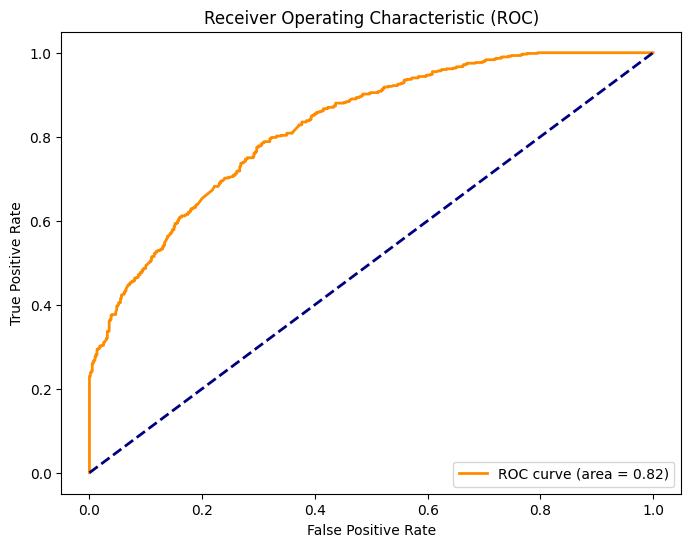

In [ ]:
# Start plotting
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

## Confusion Matrix

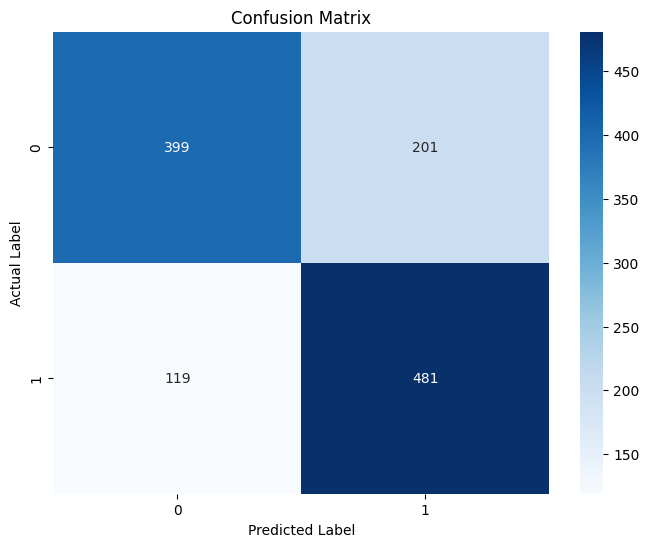

In [ ]:
# Compute the confusion matrix
cm = confusion_matrix(y_test, predictions)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

# Keras vs Treditional ML

#AUC for Both

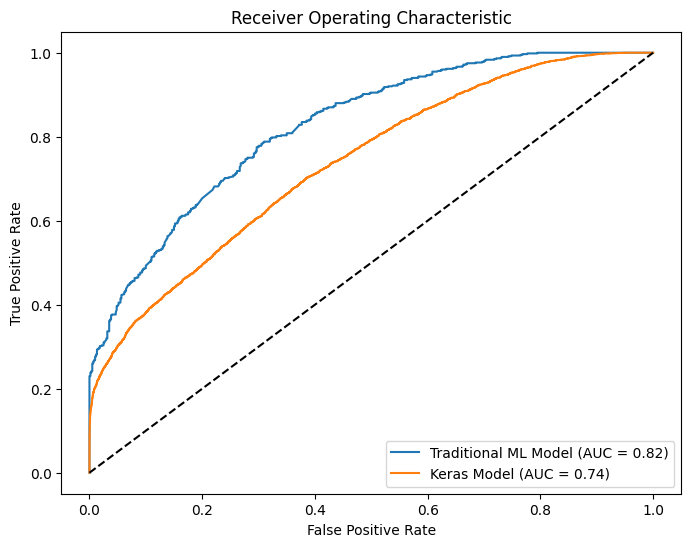

In [ ]:
import matplotlib.pyplot as plt

# Plot ROC curves for both models
plt.figure(figsize=(8, 6))

# Plot for the traditional ML model
plt.plot(fpr, tpr, label=f'Traditional ML Model (AUC = {roc_auc:.2f})')

# Plot for the Keras model
plt.plot(fpr_keras, tpr_keras, label=f'Keras Model (AUC = {roc_auc_keras:.2f})')

# Plot baseline
plt.plot([0, 1], [0, 1], 'k--')

# Axes and labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

# Show plot
plt.show()